# Demonstration of 3D gravity modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import grav

## The mesh

First, let's set up a rectlinear mesh.
xnodes, ynodes, and znodes are 1D vectors.
They hold the x, y, and z coordinates of the mesh nodes.

In [2]:
xnodes = np.linspace(0,200,3)
ynodes = np.linspace(0,300,4)
znodes = np.linspace(0,400,5)

Since there is one fewer block in each direction than there are nodes,

In [3]:
nx = len(xnodes)-1
ny = len(ynodes)-1 
nz = len(znodes)-1

So, the mesh will have m=(nx-1)(ny-1)(nz-1) total rectangular blocks.
All distances are in meters.
x is northing, y is easting, z is positive down.

## Observation locations

locs is an nx3 matrix of observation locations.
Note: z is positive down, so negative z values correspond to locations above the surface, and positive z values to locations below.
I'm not sure things work right when z is positive (when an observation location is inside a block)!

In [4]:
# A mostly straight east-to-west line of observations
xlocs = [40,43,41,42]
ylocs = [250,200,150,100]
zlocs = [-50,-25,-30,-45]

locs = np.array([xlocs,ylocs,zlocs]).T
locs.shape

(4, 3)

## Sensitivity matrix

The sensitivity matrix G describes each data point's sensitivity to an change in density in each block. It is nxm where n is the number of observation locations, and m is the number of blocks.
Each row of G corresponds to one observation location.
Each column of G corresponds to one block in the model.

In [5]:
G = grav.sens3d(xnodes,ynodes,znodes,locs)
G.shape

(4, 24)

The way the columns (blocks) are ordered within G is a bit funny. 
G[:,0] corresponds to the block in the upper southwest corner.
G[:,1] corresponds to one block lower, in the southwest corner.
And so on, until you get to the bottom block in the southwest corner.
Call it G[:,nz].
Then, G[:,nz+1] corresponds to the block that is one to the east of the upper southwest corner.
And so on.

In other words, the columns of G are ordered such that they vary fastest in z (from top to bottom), then in y (from west to east), then in x (from south to north).

The rows of G are ordered the same as the rows of locs, as you would expect.

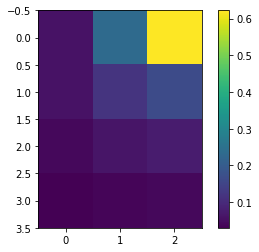

In [6]:
# get the row of G that corresponds to the first observation location
# reshape it, so that we can index it as G0[ix,iy,iz]
G0 = G[0,:].reshape(nx,ny,nz)
# now pull out only the cross-section for ix=0
G00 = G0[0,:,:]
# plot it such that y is positive right and z is positive down
plt.imshow(G00.T)
plt.colorbar()

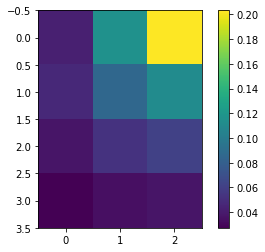

In [7]:
# now pull out only the cross-section for ix=1 and plot it
G01 = G0[1,:,:]
plt.imshow(G01.T)
plt.colorbar()

## Forward modeling

To forward model, you must form a vector that holds the density contrasts (as g/cm^3) of each block, ordered the same as the columns of G (fastest in z, then y, then x).

In [8]:
# Homogeneous density
density = np.array([0.]*G.shape[1])
# Reshape to make it easier to index
density = density.reshape(2,3,4)

# Add an anomaly, kind of in the middle
density[0,1,1] = 0.25
density[0,1,2] = 0.5
density[0,2,1] = 0.2
density[0,2,2] = 0.4

# Reshape again to turn back into a vector
density = density.flatten()
density.shape

(24,)

To compute data, multiply G and the density vector (G \* rho = d). Data are reported in milliGals.

In [9]:
data = G.dot(density)
data

array([0.12404797, 0.16218949, 0.14926607, 0.11553879])

Sanity check: approximate the density anomaly as a sphere, and compute g = gamma * m / R^2

In [10]:
6.67*10**(-3)*(.3*100*200*200)/(230**2)

0.15130434782608695

Seems reasonably close.

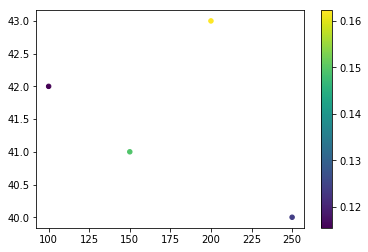

In [16]:
plt.scatter(ylocs,xlocs,20,data)
plt.colorbar()
plt.show()